In [2]:
import pandas as pd
import matplotlib.pyplot as mpl
from sklearn import linear_model
from scipy.stats import ttest_ind
import numpy as np

### Import Data from CSV

In [3]:
CACI_data = pd.read_csv("CACI_InterviewAssessment_BillDefaults_Data.csv")

### Organising Data
* Checking for nulls
* Removing unneeded columns
* Converting non-numeric to numeric

In [4]:
CACI_data.drop(['uid'], axis=1, inplace=True)
print(CACI_data.isnull().values.any())

# C = Cash,cheque and card = 0
# D = Direct debit = 1
# P = prepayment meter = 2
CACI_data['cli_payment'] = CACI_data.loc[:, 'cli_payment'].replace({'C': 0, 'D': 1, 'P': 2})

False


### Creating Boxplots to compare variables to late_default

In [5]:
def boxplot(data, compare_to):
    """Create boxplot to compare each variable to y variable"""
    list_of_columns = [col for col in data.columns]
    for variable in list_of_columns:
        data.boxplot(column=variable, by=compare_to, showfliers=False)
        mpl.show()

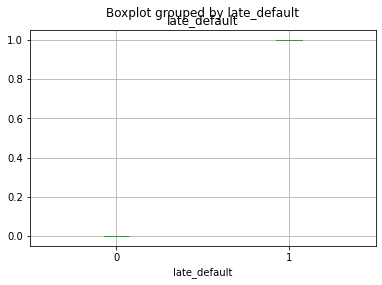

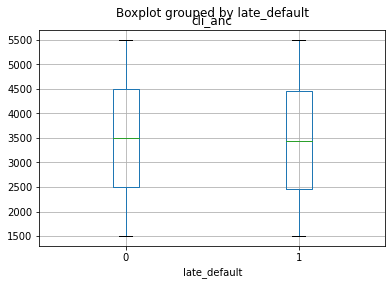

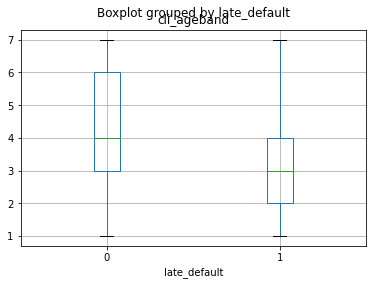

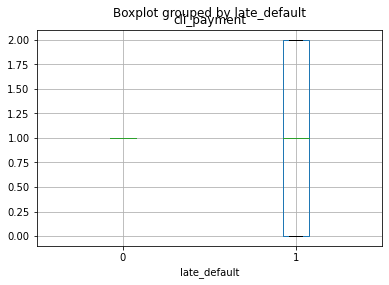

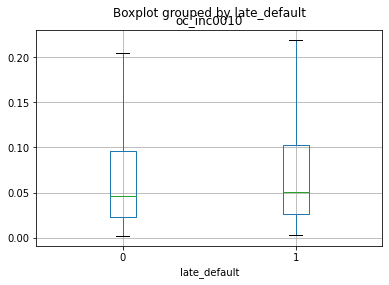

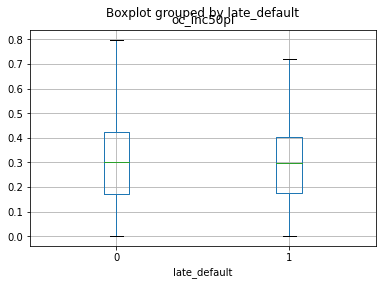

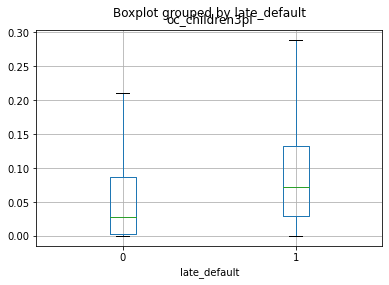

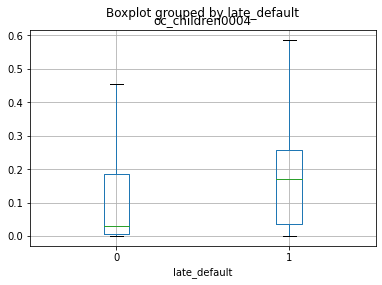

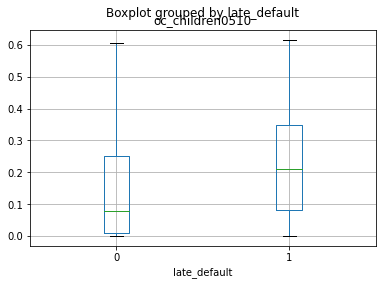

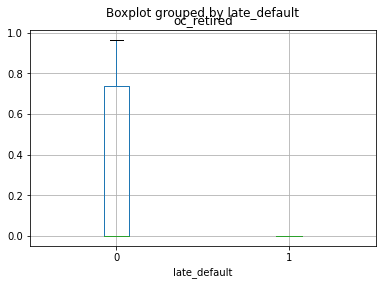

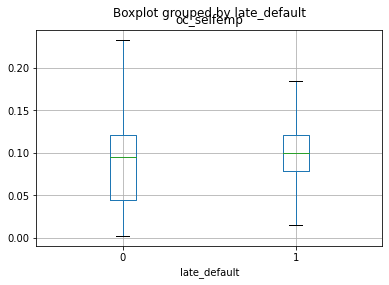

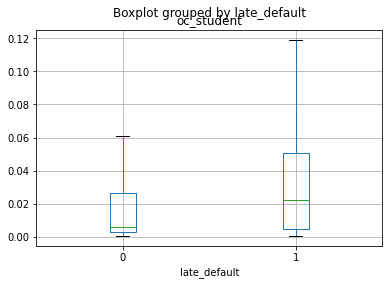

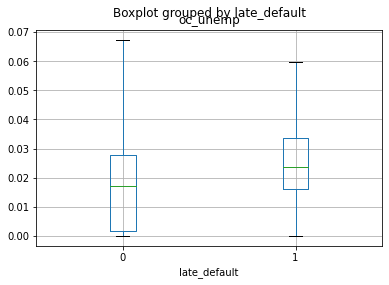

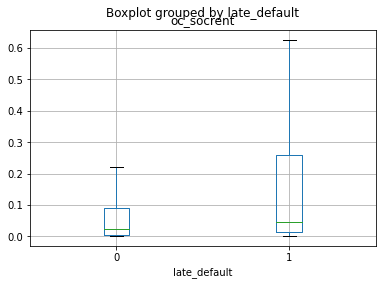

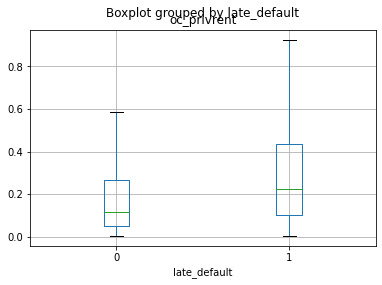

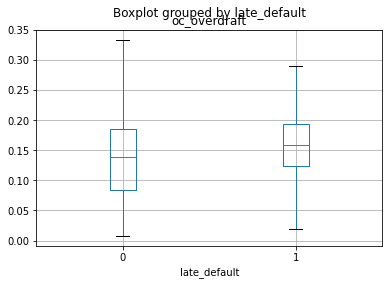

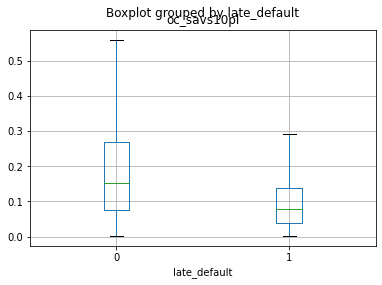

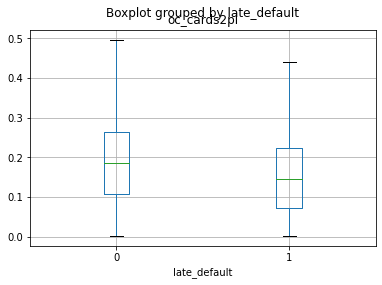

In [6]:
boxplot(CACI_data, 'late_default')

### Creating Barchart

In [7]:
def barchart_late(data, group_by: str, xlabel: str, ylabel: str, title,variable_parts: list):
    """"Create Barchart comparing variables by late_default"""
    df_late_size=CACI_data[CACI_data['late_default']==1].groupby(group_by).size()
    df_size=CACI_data[CACI_data['late_default']==0].groupby(group_by).size()

    r = np.arange(len(CACI_data.groupby(group_by).size()))
    width = 0.25

    mpl.bar(r, df_size, width=width, label='Paid')
    mpl.bar(r+width , df_late_size, width=width, label='late')

    mpl.xlabel(xlabel)
    mpl.ylabel(ylabel)
    mpl.title(title)

    mpl.xticks(r + width/2, variable_parts)
    mpl.legend()
    mpl.show()

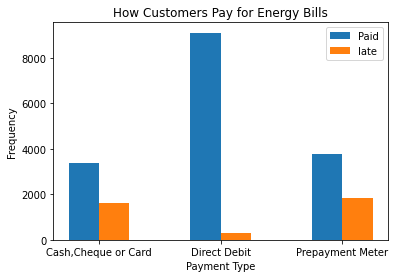

In [8]:
barchart_late(CACI_data, 'cli_payment', 'Payment Type', 'Frequency', 'How Customers Pay for Energy Bills', ['Cash,Cheque or Card', 'Direct Debit', 'Prepayment Meter'])

### Create Pie Charts

In [9]:
def pie_chart(data, variable: str, key_list: list):
    """Creating Pie charts"""
    groupby_data=data.groupby(variable).size()
    mpl.pie(groupby_data, labels=groupby_data, autopct='%.2f%%')
    mpl.legend(key_list,bbox_to_anchor=(-0.4,0.3), loc='upper left')
    mpl.show()

In [10]:
def pie_chart_late(data, variable, key_list):
    """Create Pie Chart for only late or defaulted customers"""
    groupby_data=data[data['late_default']==1].groupby(variable).size()
    mpl.pie(groupby_data, labels=groupby_data, autopct='%.2f%%')
    mpl.legend(key_list,bbox_to_anchor=(-0.4,0.3), loc='upper left')
    mpl.show()

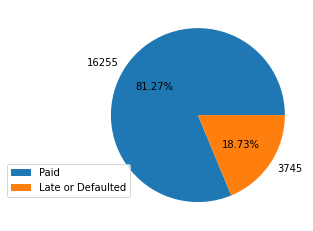

In [11]:
late_type = ['Paid', 'Late or Defaulted']
pie_chart(CACI_data, 'late_default',late_type)

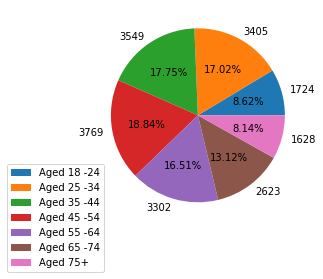

In [12]:
age_band = ['Aged 18 -24', 'Aged 25 -34', 'Aged 35 -44', 'Aged 45 -54', 'Aged 55 -64', 'Aged 65 -74', 'Aged 75+']
pie_chart(CACI_data, 'cli_ageband', age_band)

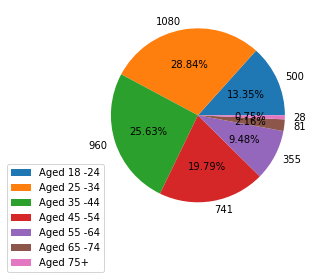

In [13]:
pie_chart_late(CACI_data, 'cli_ageband', age_band)

### Creating Independent and Dependent Variable

In [14]:
class Variables(object):
    """Class to create dependent and independent variables"""
    def __init__(self, dataframe: pd.DataFrame):
        self.input_dataframe = dataframe

    def dependent(self, dependent_variable):
        """"The dependent variable"""
        return self.input_dataframe[dependent_variable]

    def independent(self, list_of_independent: list) -> pd.DataFrame:
        """The independent variable"""
        return self.input_dataframe[list_of_independent]

In [15]:
# list_dep_vars = CACI_data.drop(columns=['late_default', 'oc_selfemp', 'oc_inc50pl', 'oc_socrent', 'oc_overdraft', 'cli_anc', 'oc_inc0010']).columns
# data_vars = Variables(CACI_data)
# dep = data_vars.dependent('late_default')
# indep = data_vars.independent(list_dep_vars)

In [16]:
list_dep_vars = CACI_data.drop(columns=['oc_inc0010','oc_inc50pl','oc_children3pl','oc_children0004','oc_children0510','oc_privrent','oc_savs10pl','oc_cards2pl','cli_anc']).columns
data_vars = Variables(CACI_data)
dep = data_vars.dependent('late_default')
indep = data_vars.independent(list_dep_vars)
indep

,late_default,cli_ageband,cli_payment,oc_retired,oc_selfemp,oc_student,oc_unemp,oc_socrent,oc_overdraft
0,1,2,2,0.000031,0.150273,0.042310,0.025378,0.012832,0.172783
1,0,4,1,0.001478,0.118803,0.007655,0.075782,0.750370,0.114262
2,0,6,1,0.817904,0.021434,0.002262,0.000317,0.026640,0.056320
3,0,3,1,0.000132,0.101393,0.023778,0.029276,0.022806,0.184631
4,0,4,1,0.001453,0.119810,0.002274,0.031067,0.001271,0.181568
...,...,...,...,...,...,...,...,...,...
19995,0,3,0,0.000153,0.091035,0.011942,0.020050,0.030269,0.197441
19996,0,2,1,0.000034,0.079453,0.043436,0.017367,0.213339,0.136288
19997,0,1,2,0.000054,0.036993,0.334451,0.029190,0.023805,0.100020
19998,1,3,2,0.000116,0.128175,0.018341,0.012351,0.053193,0.241522


### Creating and Assess Logistic Regression Model

In [17]:
class LogisticRegressionModel(object):
    """ Create and Asses accuracy of the model """
    def __init__(self):
        self.independent = None
        self.dependent = None
        self.log_model = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)


    def logistic_model(self, independent, dependent):
        """Creat Logistic Regression Model using independent and dependent variables"""
        self.independent = independent
        self.dependent = dependent
        return  self.log_model.fit(X=self.independent, y=self.dependent)


    @property
    def model_coefficients(self):
        """Show model coefficients"""
        return pd.Series(self.log_model.coef_[0], index=self.independent.columns.values)


    @property
    def accuracy(self):
        """Assess accuracy of the model"""
        return self.log_model.score(X=self.independent, y=self.dependent)


    @property
    def prediction_data(self):
        """Create prediction data based on independent data"""
        return self.log_model.predict(X=self.independent)


    @property
    def confusion_matrix(self):
        """Create confusion matrix, compare dependent and prediction data"""
        return pd.crosstab(self.prediction_data, self.dependent)


In [18]:
log_model = LogisticRegressionModel()
log_model.logistic_model(indep, dep)
log_model.confusion_matrix

late_default,0,1
row_0,,
0,16255,0
1,0,3745


In [19]:
log_model.accuracy

1.0

### T-test

In [20]:
def ttest(data):
    """Assess for significant different between the means of data columns"""
    for n in range (len(data.columns)):
        df_late_size=CACI_data[CACI_data['late_default']==1].groupby(CACI_data.columns[n]).size()
        df_size=CACI_data[CACI_data['late_default']==0].groupby(CACI_data.columns[n]).size()
        result = ttest_ind(df_late_size,df_size)
        if result[1] < 0.05:
            print(data.columns[n])
            print(result)

In [21]:
ttest(CACI_data)

cli_anc
Ttest_indResult(statistic=-94.84151189536828, pvalue=0.0)
cli_ageband
Ttest_indResult(statistic=-5.978913106773932, pvalue=6.421379443764894e-05)
oc_retired
Ttest_indResult(statistic=5.316810918824044, pvalue=1.0723429181090858e-07)
oc_selfemp
Ttest_indResult(statistic=-2.4031674589104957, pvalue=0.01626343345752433)
oc_student
Ttest_indResult(statistic=-2.1311883550546957, pvalue=0.03308663172058405)
oc_unemp
Ttest_indResult(statistic=-2.875614202395604, pvalue=0.0040369867644926664)
oc_socrent
Ttest_indResult(statistic=-4.075708551826091, pvalue=4.606215596971442e-05)
oc_overdraft
Ttest_indResult(statistic=-2.1163222228719922, pvalue=0.034330332338569566)


D:\Repository\Projects\Coding\Python\skeleton_py3\venv\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\Repository\Projects\Coding\Python\skeleton_py3\venv\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
cor_check = CACI_data.corr()
cor_check.values > 0.9

array([[ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False],

In [23]:
len(cor_check == 'True') == len(cor_check.columns)

True